In [25]:
%matplotlib inline
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set(style="darkgrid")

PATH = '/home/st/Documents/Uni/Masterarbeit/Data/2024-03-07_rows.json'

MAX_ANSWERS = 4
FIG_SIZE = (10, 5)

rows = json.load(open(PATH, 'r'))
rows_df = pd.DataFrame(rows)
question_rows = []
all_annotations = []
x = []

for row in rows:
    x.append(row['language'])
    for question in row['questions']:
        question_row = row.copy()
        annotations = [annotation for annotation in question['annotations'] if
                       not annotation['skipped'] and not annotation['archived']]
        question_row['question'] = question['question']

        for index, annotation in enumerate(annotations):
            annotation_row = {
                **annotation,
                'selected': len(annotation['answerLines']),
                'context': row['context'],
                'answerCount': len(row['context'].split('\n')) - 1
            }
            all_annotations.append(annotation_row)
            
            question_row[f'answers{index}'] = annotation['answerLines']
            question_row[f'noAnswer{index}'] = annotation['noAnswer']
            question_row[f'user{index}'] = annotation['user']

        question_rows.append(question_row)

print(set(x))
questions_df = pd.DataFrame(question_rows,
                            columns=['question', 'answers0', 'answers1', 'noAnswer0', 'noAnswer1', 'context', 'city',
                                     'language'])
annotations_df = pd.DataFrame(all_annotations)

selected_answers_all = annotations_df.selected.sum()
total_answers_all = annotations_df.answerCount.sum()
selected_percentage_all = selected_answers_all / total_answers_all
p_selected_agreement_all = pow(selected_percentage_all, 2)

selected_answers = annotations_df[annotations_df.selected <= MAX_ANSWERS].selected.sum()
total_answers = annotations_df[annotations_df.selected <= MAX_ANSWERS].answerCount.sum()
selected_percentage = selected_answers / total_answers
p_selected_agreement = pow(selected_percentage, 2)
print(p_selected_agreement_all, selected_percentage_all)
print(p_selected_agreement, selected_percentage)

{'en', 'de'}
0.022566782837712854 0.15022244452049385
0.0030162790069978304 0.054920661021129656


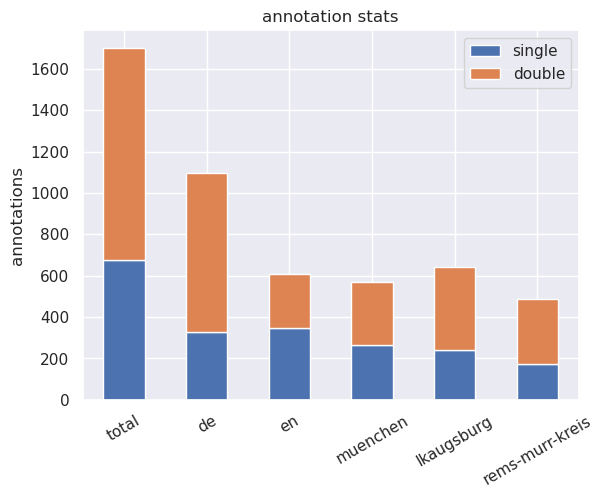

In [26]:
# Annotations stats
def plot_stacked(axis, df, title, y_label, x_ticks, y_ticks=None, x_label=''):
    df.plot.bar(ax=axis, rot=30, stacked=True)
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_xticklabels(x_ticks)
    if y_ticks is not None:
        axis.set_yticks(y_ticks)


def plot_annotation_stats(dfs, x_ticks):
    _, axis = plt.subplots()
    annotation_stats_df = pd.DataFrame([[df.answers0.count() - df.answers1.count(), df.answers1.count()] for df in dfs],
                                       columns=['single', 'double'])
    plot_stacked(axis, annotation_stats_df, 'annotation stats', 'annotations', x_ticks)

plot_annotation_stats(
    [questions_df, questions_df[questions_df['language'] == 'de'], questions_df[questions_df['language'] == 'en'],
     questions_df[questions_df['city'] == 'muenchen'], questions_df[questions_df['city'] == 'lkaugsburg'],
     questions_df[questions_df['city'] == 'rems-murr-kreis']],
    ['total', 'de', 'en', 'muenchen', 'lkaugsburg', 'rems-murr-kreis'])

Average document length (chars): 1648.37
Median document length (chars): 1371
Average document length (sentences): 26.8
Median document length (sentences): 22


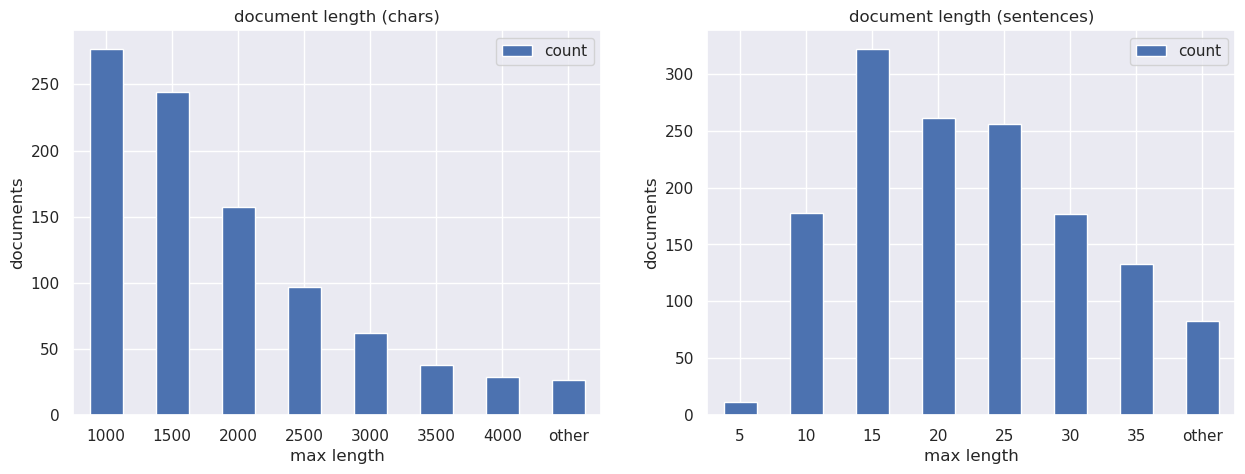

In [45]:
# Document length stats
documents_df = pd.DataFrame(rows)


def plot_counts(axis, column, title, x_label, y_label, digits=0, x_label_rot=0):
    value_count_df = column.value_counts().reset_index()
    value_count_df.columns = ['value', 'count']
    value_count_df = value_count_df.sort_values('value')

    value_count_df.plot.bar(ax=axis, rot=x_label_rot, color='b')
    axis.set_xticklabels([f'{int(value) if digits == 0 else round(value, ndigits = digits)}' for value in value_count_df['value']])
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

    print(f'Average {title}: {round(column.mean(), 2)}')
    print(f'Median {title}: {int(column.median())}')


def plot_count_bins(axis, column, bins, title, x_label, y_label, digits=0, x_label_rot=0, other=True):
    bins_df = pd.cut(column, bins=bins, include_lowest=True).value_counts().reset_index()
    bins_df.columns = ['bin', 'count']
    bins_df['sort'] = bins_df.bin.map(lambda x: x.left)
    bins_df = bins_df.sort_values('sort')

    bins_df.plot.bar(ax=axis, rot=x_label_rot, color='b')
    axis.set_xticklabels([f'{int(bin.right) if digits == 0 else round(bin.right, ndigits = digits)}' if bin.right != bins[-1] or not other else 'other' for bin in bins_df['bin']])
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

    print(f'Average {title}: {round(column.mean(), 2)}')
    print(f'Median {title}: {int(column.median())}')


group_by_context_length = rows_df.context.str.len().value_counts().reset_index()
group_by_context_length.columns = ['document_length', 'document']

tmp = rows_df.copy()
group_by_answer_count = rows_df.copy()
group_by_answer_count['document_length'] = tmp.apply(lambda x: len(x.context.split('\n')) - 1, axis=1)
group_by_answer_count = group_by_answer_count.reset_index()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_count_bins(ax1, group_by_context_length.document_length,
                numpy.array([0, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 10000]), 'document length (chars)',
                'max length', 'documents')
plot_count_bins(ax2, group_by_answer_count.document_length, numpy.array([0, 5, 10, 15, 20, 25, 30, 35, 40]),
                'document length (sentences)', 'max length', 'documents')

In [28]:
# Prepare questions with two annotations
double_annotations_df = questions_df[~questions_df.answers0.isnull() & ~questions_df.answers1.isnull()].copy()
double_annotations_df['intersection'] = double_annotations_df.apply(lambda x: list(set(x.answers0).intersection(set(x.answers1))), axis=1)
double_annotations_df['union'] = double_annotations_df.apply(lambda x: list(set(x.answers0).union(set(x.answers1))), axis=1)
double_annotations_df['jaccard'] = double_annotations_df.apply(lambda x: len(x.intersection) / len(x.union) if len(x.union) > 0 else 1, axis=1)
double_annotations_df['jaccard_cc'] = double_annotations_df.apply(lambda x: (x.jaccard - p_selected_agreement) / (1 - p_selected_agreement), axis=1)
double_annotations_df['jaccard_cc_all'] = double_annotations_df.apply(lambda x: (x.jaccard - p_selected_agreement_all) / (1 - p_selected_agreement_all), axis=1)
double_annotations_df['diff0'] = double_annotations_df.apply(lambda x: list(set(x.answers0).difference(x.answers1)), axis=1)
double_annotations_df['diff1'] = double_annotations_df.apply(lambda x: list(set(x.answers1).difference(x.answers0)), axis=1)
filtered_double_annotations_df = double_annotations_df[(double_annotations_df.answers0.str.len() <= MAX_ANSWERS) & (double_annotations_df.answers1.str.len() <= MAX_ANSWERS)]

In [29]:
# Plotting helpers
def print_row(values, width=10):
    print(' | '.join([f'{it:^{width}}' for it in values]))


def print_absolute_percentage_row(values, divisor, width=10):
    print_row(values[:1] + [f'{value} ({int(value / divisor * 100)}%)' for value in values[1:]], width)

Average jaccard index (max 4 answers): 0.51
Median jaccard index (max 4 answers): 0
Average jaccard index (all): 0.38
Median jaccard index (all): 0


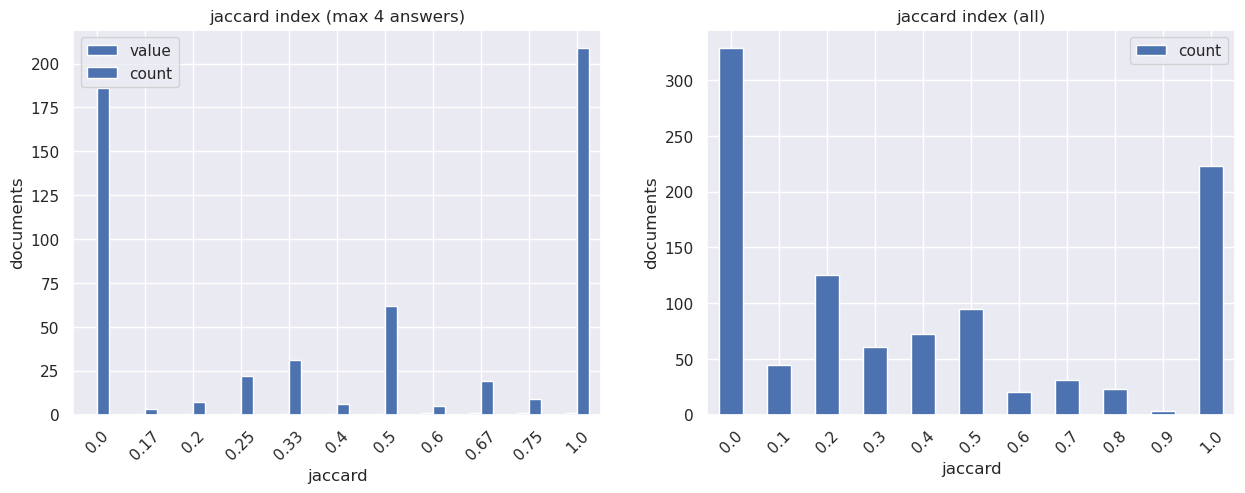

In [55]:
# Plot intersection over union / Jaccard-Index
# print(round(filtered_double_annotations_df.jaccard.mean(), 4))
# print(round(filtered_double_annotations_df.jaccard_cc.mean(), 4))
# print(round(double_annotations_df.jaccard.mean(), 4))
# print(round(double_annotations_df.jaccard_cc_all.mean(), 4))

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plot_counts(ax1, filtered_double_annotations_df.jaccard, f'jaccard index (max {MAX_ANSWERS} answers)', 'jaccard', 'documents', digits=2, x_label_rot=45)
plot_count_bins(ax2, double_annotations_df.jaccard, numpy.arange(-0.1, 1.01, 0.1), 'jaccard index (all)', 'jaccard', 'documents', digits=2, x_label_rot=45, other=False)

 answers   | agreement  | one-sided  |  overlap   | no agreement
   < 2     | 199 (52%)  |  45 (11%)  |   8 (2%)   | 124 (32%) 
   < 3     | 204 (43%)  |  85 (18%)  |  22 (4%)   | 158 (33%) 
   < 4     | 209 (37%)  | 121 (21%)  |  43 (7%)   | 186 (33%) 
   < 5     | 214 (32%)  | 147 (22%)  |  70 (10%)  | 218 (33%) 
   < 7     | 219 (28%)  | 188 (24%)  |  98 (12%)  | 258 (33%) 
   < 10    | 220 (25%)  | 228 (25%)  | 136 (15%)  | 293 (33%) 
   all     | 221 (21%)  | 296 (28%)  | 180 (17%)  | 329 (32%) 


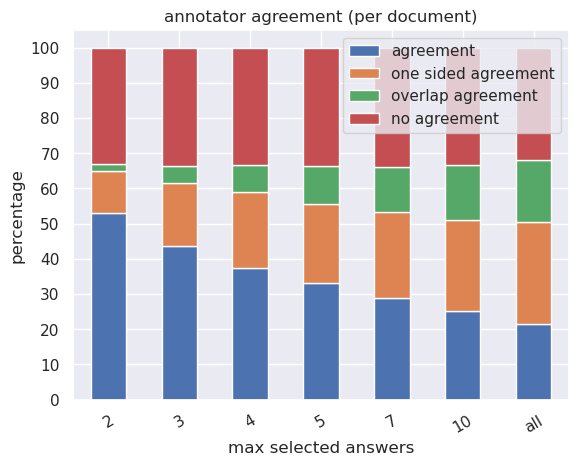

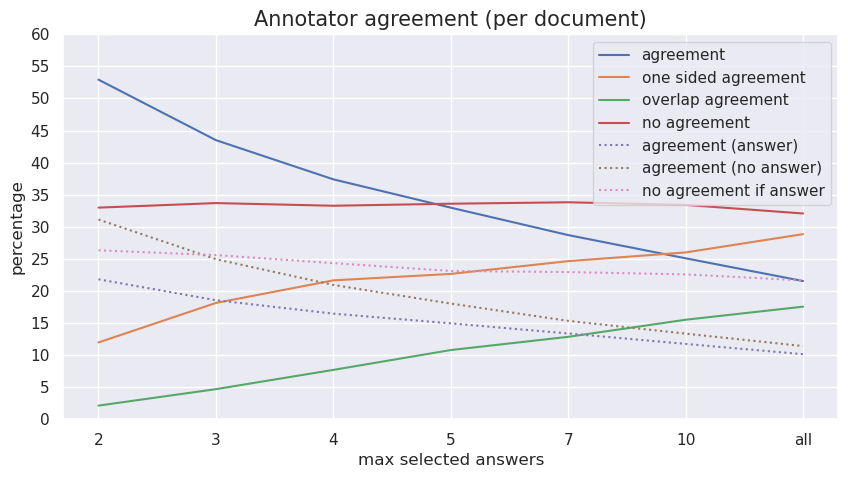

In [38]:
# Plot annotator agreement (per document)
max_answers_thresholds = [2, 3, 4, 5, 7, 10]
agreement_options = ['answers', 'agreement', 'one-sided', 'overlap', 'no agreement']
columns = ['agreement', 'one sided agreement', 'overlap agreement', 'no agreement', 'agreement (answer)',
           'agreement (no answer)', 'no agreement if answer']


def get_annotator_agreement(df, name):
    total_count = len(df)
    raw_agreement = len(df[(df.diff0.str.len() == 0) & (df.diff1.str.len() == 0)])
    raw_agreement_one_sided = len(
        df[((df.diff0.str.len() == 0) != (df.diff1.str.len() == 0)) & (df.intersection.str.len() > 0)])
    raw_agreement_overlap = len(
        df[(df.diff0.str.len() > 0) & (df.diff1.str.len() > 0) & (df.intersection.str.len() > 0)])
    raw_no_agreement = len(
        df[((df.answers0.str.len() > 0) | (df.answers1.str.len() > 0)) & (df.intersection.str.len() == 0)])
    raw_agreement_no_answer = len(df[(df.answers0.str.len() == 0) & (df.answers1.str.len() == 0)])
    raw_agreement_answer = raw_agreement - raw_agreement_no_answer
    raw_no_agreement_answer = len(df[(df.answers0.str.len() == 0) != (df.answers1.str.len() == 0)])

    print_absolute_percentage_row(
        [name, raw_agreement, raw_agreement_one_sided, raw_agreement_overlap, raw_no_agreement], total_count)
    raw = [raw_agreement, raw_agreement_one_sided, raw_agreement_overlap, raw_no_agreement, raw_agreement_answer,
           raw_agreement_no_answer, raw_no_agreement_answer]

    return [it / total_count * 100 for it in raw]


def get_double_annotations_max_answers(df, max_answers):
    return df[(df.answers0.str.len() <= max_answers) & (df.answers1.str.len() <= max_answers)]


def get_max_answers_agreement(df):
    agreements = []
    print_row(agreement_options)
    for max_answers in max_answers_thresholds:
        agreements.append(get_annotator_agreement(get_double_annotations_max_answers(df, max_answers),
                                                  f'< {max_answers}{"" if len(str(max_answers)) == 2 else " "}'))
    agreements.append(get_annotator_agreement(df, 'all '))

    return pd.DataFrame(agreements)


x_ticks = max_answers_thresholds + ['all']
y_ticks = numpy.arange(0, 110, 10)
max_answers_agreement_df = get_max_answers_agreement(double_annotations_df)
max_answers_agreement_df.columns = columns
_, axis = plt.subplots()
plot_stacked(axis, max_answers_agreement_df.copy().iloc[:, :4], title='annotator agreement (per document)',
             x_label='max selected answers', y_label='percentage', x_ticks=x_ticks, y_ticks=y_ticks)

_, ax = plt.subplots(figsize=FIG_SIZE)
ax.set_title('Annotator agreement (per document)', fontsize=15)
ax.set_xlabel('max selected answers')
ax.set_ylabel('percentage')

for index in range(len(max_answers_agreement_df.columns)):
    max_answers_agreement_df.iloc[:, index].plot.line(ax=ax, linestyle='-' if index < 4 else ':')

ax.legend(columns)
ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
ax.set_xticklabels(x_ticks)
ax.set_yticks(numpy.arange(0, 65, 5))
ax.set_ylim(0)
plt.show()

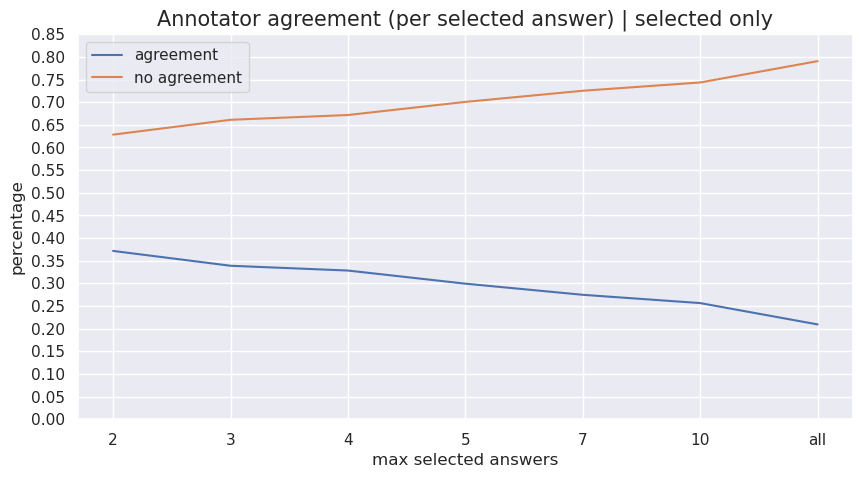

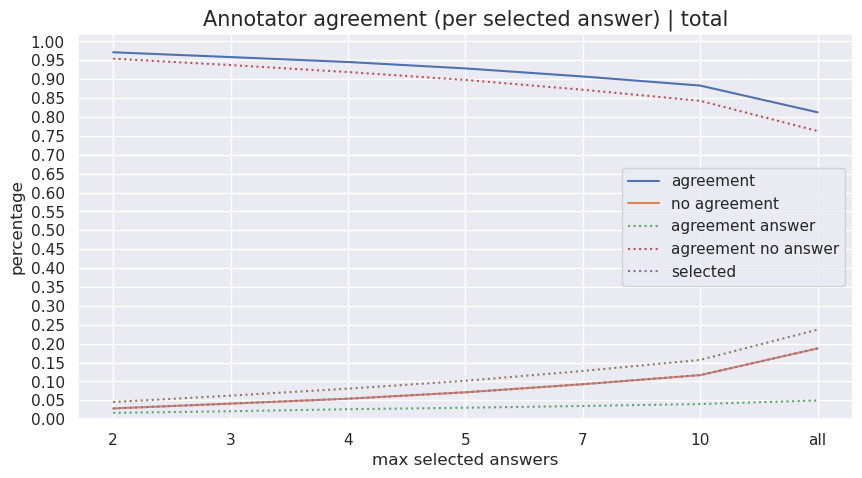

In [32]:
# Plot annotator agreement (per answer)
def get_annotator_agreement_per_answer(df, selected_only):
    raw_agreement_answer = 0
    raw_agreement_no_answer = 0
    raw_no_agreement = 0
    total = 0
    total_selected = 0

    for _, row in df.iterrows():
        possible_answers = len(row.context.split('\n'))
        total += possible_answers - 1
        for i in range(1, possible_answers):
            if i in row.answers0 and i in row.answers1:
                raw_agreement_answer += 1
            elif i not in row.answers0 and i not in row.answers1:
                raw_agreement_no_answer += 1
            else:
                raw_no_agreement += 1

            if i in row.answers0 or i in row.answers1:
                total_selected += 1

    if selected_only:
        agreement_answer = raw_agreement_answer / total_selected
        no_agreement = raw_no_agreement / total_selected
        return [agreement_answer, no_agreement]

    agreement = (raw_agreement_answer + raw_agreement_no_answer) / total
    no_agreement = raw_no_agreement / total
    agreement_answer = raw_agreement_answer / total
    agreement_no_answer = raw_agreement_no_answer / total
    return [agreement, no_agreement, agreement_answer, agreement_no_answer, no_agreement, total_selected / total]


def get_max_answers_agreement_per_answer(df, selected_only):
    agreements = []
    for max_answers in max_answers_thresholds:
        agreements.append(
            get_annotator_agreement_per_answer(get_double_annotations_max_answers(df, max_answers), selected_only))
    agreements.append(get_annotator_agreement_per_answer(df, selected_only))

    return pd.DataFrame(agreements)


selected_only_params = [True, False]
for selected_only in selected_only_params:
    max_answers_agreement_per_answer_df = get_max_answers_agreement_per_answer(double_annotations_df, selected_only)

    x_labels = [f'{max_answers}' for max_answers in max_answers_thresholds]
    x_labels.append('all')

    _, ax = plt.subplots(figsize=FIG_SIZE)
    ax.set_xlabel('max selected answers')
    ax.set_ylabel('percentage')

    for index in range(len(max_answers_agreement_per_answer_df.columns)):
        max_answers_agreement_per_answer_df.iloc[:, index].plot.line(ax=ax, linestyle='-' if index < 2 else ':')

    if selected_only:
        ax.set_title('Annotator agreement (per selected answer) | selected only', fontsize=15)
        ax.legend(['agreement', 'no agreement'])
        ax.set_yticks(numpy.arange(0, 0.90, 0.05))
    else:
        ax.set_title('Annotator agreement (per selected answer) | total', fontsize=15)
        ax.legend(['agreement', 'no agreement', 'agreement answer', 'agreement no answer', 'selected'])
        ax.set_yticks(numpy.arange(0, 1.05, 0.05))
    ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0)
    plt.show()

Average selected answers: 4.18
Median selected answers: 2


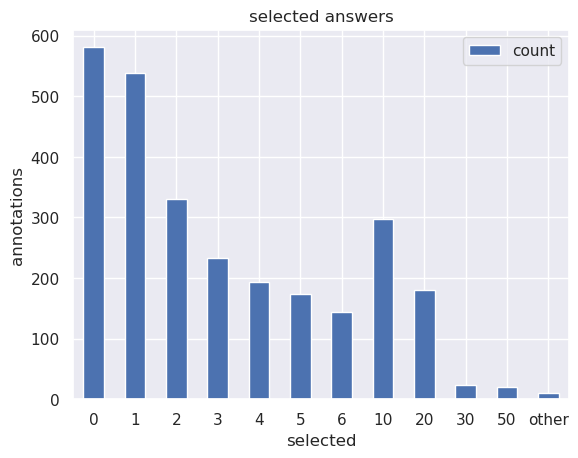

In [57]:
# Plot selection count
_, axis = plt.subplots()
plot_count_bins(axis, annotations_df.selected, [-1, 0, 1, 2, 3, 4, 5, 6, 10, 20, 30, 50, 1000], 'selected answers',
                'selected', 'annotations', digits=0)

Total annotators: 171
Total annotations: 2728
Average annotations per annotator: 15.95
Median annotations per annotator: 7


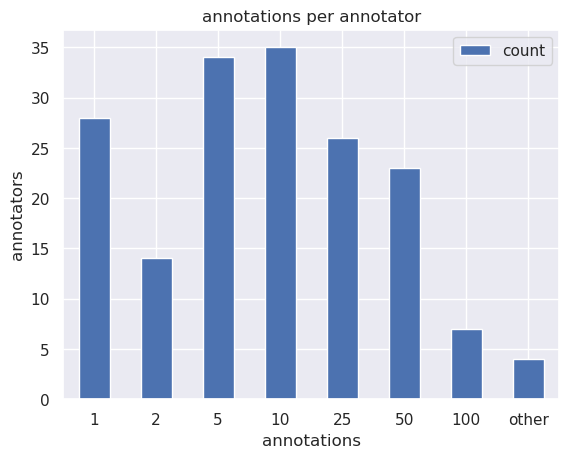

In [56]:
# Plot user contributions
group_by_user = annotations_df.user.value_counts().reset_index()
group_by_user.columns = ['user', 'annotations']
print('Total annotators:', len(group_by_user))
print('Total annotations:', len(annotations_df))

_, axis = plt.subplots()
plot_count_bins(axis, group_by_user.annotations, [0, 1, 2, 5, 10, 25, 50, 100, 1000], 'annotations per annotator',
                'annotations', 'annotators', digits=0)